# Project: 🛡️ Detection of Anomalies in Bank Transactions
💡 Objective: Use Machine Learning to identify suspicious transactions in real time.

Dataset: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

# Load the Dataset

In [1]:
import pandas as pd

In [2]:
# Load the CSV file
file_path = "raw_data/Fraud.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# EDA analysis

In [3]:
# Dataset dimensions
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# General information about columns and data types
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

The dataset contains 6362620 rows and 11 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


#### Observations:

Key columns:
amount: Transaction amount.
type: Transaction type (e.g., PAYMENT, TRANSFER, CASH_OUT).
isFraud: Target variable (1 = Fraud, 0 = Legitimate).
isFlaggedFraud: Transactions flagged as fraudulent by the system.

## Data Cleaning & Feature Engineering

### Drop Unnecessary Columns
Since nameOrig and nameDest are just identifiers and don't provide useful numerical features for fraud detection, we can safely remove them.

In [4]:
# Drop nameOrig and nameDest
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

# Verify the columns were removed
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


## Convert Categorical Variables (type) to Numerical
The type column contains transaction types such as PAYMENT, TRANSFER, CASH_OUT, etc.. We need to convert these into numbers.

One-Hot Encoding (OHE) → Creates a new column for each type (e.g., type_PAYMENT, type_TRANSFER). As it's often better for ML models

In [5]:
# Convert 'type' to dummy variables
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Display the first rows to check the encoding
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


## Check Class Distribution
Fraud detection datasets are often highly imbalanced

In [6]:
# Check class distribution (assuming the fraud label is 'Class')
if 'isFraud' in df.columns:
    print(df['isFraud'].value_counts(normalize=True) * 100)
else:
    print("The target column 'isFraud' was not found. Please verify the column name.")

0    99.870918
1     0.129082
Name: isFraud, dtype: float64


## Feature Scaling
Since some numerical features (e.g., amount, oldbalanceOrg, newbalanceOrig) have different scales, we should normalize them.
We will scale the numerical features using StandardScaler, which transforms data to have zero mean and unit variance.

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
# Select numerical columns to scale (excluding target variables)
features_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected features
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Display the first few rows to confirm scaling
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0,0,1,0
1,1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0,0,1,0
2,1,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,1,0,0,0,0,1
3,1,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,0,1,0,0,0
4,1,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0,0,1,0


## Train-Test Split
Before applying any resampling techniques (like SMOTE or undersampling), let's split the dataset into training and testing sets. 📌 Why stratify=y? → Ensures the train/test sets keep the same fraud ratio as the original dataset.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Define features (X) and target variable (y)
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the splits
X_train.shape, X_test.shape

((5090096, 11), (1272524, 11))

## Handling Class Imbalance
Since fraud cases make up only 0.13% of the dataset, we need to balance the classes before training a model.

## Apply SMOTE (Synthetic Minority Over-sampling Technique)
Creates synthetic fraudulent transactions to balance the dataset.
Useful for ML models like Decision Trees, Logistic Regression, etc.
We apply it only on the training set to avoid data leakage.

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=42)  # Increase fraud cases to 20% of dataset

# Apply SMOTE on training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print(y_train_resampled.value_counts(normalize=True) * 100)

0    83.333336
1    16.666664
Name: isFraud, dtype: float64


🔹 Now 16.67% of the training set is fraud cases (up from 0.13% before). 
🔹 83.33% of transactions remain legitimate, preventing overfitting to fraudulent cases.

# 🚀 We'll train Random Forest, XGBoost, and a Neural Network (MLPClassifier) and compare their performance.

## Random Forest Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [26]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("🔹 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

🔹 Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.60      0.98      0.74      1643

    accuracy                           1.00   1272524
   macro avg       0.80      0.99      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



## XGBoost Model

In [14]:
from xgboost import XGBClassifier

In [27]:
# Initialize and train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("🔹 XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

🔹 XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.53      0.99      0.69      1643

    accuracy                           1.00   1272524
   macro avg       0.76      0.99      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524



##  Neural Network (MLPClassifier)

In [15]:
from sklearn.neural_network import MLPClassifier

In [28]:
# Initialize and train the neural network
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)
mlp_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate performance
print("🔹 Neural Network Performance:")
print(classification_report(y_test, y_pred_mlp))


🔹 Neural Network Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.05      0.96      0.10      1643

    accuracy                           0.98   1272524
   macro avg       0.53      0.97      0.54   1272524
weighted avg       1.00      0.98      0.99   1272524



## Model Performance Comparison: 
Here’s how each model performed based on Precision, Recall, and F1-score for detecting fraud cases (isFraud = 1).

🔹 Random Forest
Precision (Fraud): 0.60 → 60% of flagged frauds were actually frauds.
Recall (Fraud): 0.98 → Detected 98% of real fraud cases.
F1-score: 0.74
✅ Strong recall (detects almost all fraud cases).
⚠ Moderate precision (some false positives).

🔹 XGBoost
Precision (Fraud): 0.53 → 53% of flagged frauds were actually frauds.
Recall (Fraud): 0.99 → Detected 99% of real fraud cases.
F1-score: 0.69
✅ Best recall (99%), meaning almost all fraud cases are detected.
⚠ Lower precision (53%), leading to more false positives.

🔹 Neural Network (MLPClassifier)
Precision (Fraud): 0.05 → Only 5% of flagged frauds were actually frauds.
Recall (Fraud): 0.96 → Detected 96% of real fraud cases.
F1-score: 0.10
⚠ Very low precision (5%), meaning many false positives.
❌ Not ideal for fraud detection in its current setup.

🚀 Which Model is Best?

1️⃣ Best Overall: Random Forest → Highest precision (0.60) and strong recall (0.98).

2️⃣ XGBoost is a close second → Best recall (0.99), but slightly lower precision (0.53).

3️⃣ Neural Network is not working well → Precision is too low (0.05), leading to too many false alarms.


#  Improve Model Performance

🔹 Hyperparameter Tuning (Grid Search)

## Run Grid Search for RandomForestClassifier

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Run Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, scoring='f1', n_jobs=1, verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(grid_search.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Retrain Random Forest with Optimized Parameters

In [18]:
# Train Random Forest with the best parameters from Grid Search
rf_model_tuned = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model
rf_model_tuned.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf_tuned = rf_model_tuned.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print("🔹 Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_rf_tuned))


🔹 Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.60      0.98      0.74      1643

    accuracy                           1.00   1272524
   macro avg       0.80      0.99      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



## Run Grid Search for XGBoost

In [17]:
# Reduced hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.1]
}

# Run Grid Search with fewer candidates
grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_grid_xgb,
    cv=2,
    scoring='f1',
    n_jobs=1,
    verbose=1
)

grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print best parameters for XGBoost
print(grid_search_xgb.best_params_)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


### Retrain XGBoost with Best Parameters

In [17]:
# Train XGBoost with best parameters
xgb_model_tuned = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_model_tuned.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test)

# Evaluate performance
print("🔹 Tuned XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb_tuned))

🔹 Tuned XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.27      0.99      0.42      1643

    accuracy                           1.00   1272524
   macro avg       0.63      0.99      0.71   1272524
weighted avg       1.00      1.00      1.00   1272524



## Here's how your best models performed for fraud detection (isFraud = 1):

🔹 Observations:
XGBoost detects almost all fraud cases (99% recall), but has lower precision (27%), meaning it produces more false positives.
Random Forest maintains a better balance (60% precision, 98% recall) and might be more reliable in real-world fraud detection.

## Adjust the Fraud Detection Threshold

Right now, both models use a default threshold of 0.5 to classify fraud.
We can adjust the threshold to increase precision while keeping recall high.

## Find the Best Threshold for XGBoost

In [18]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get probability scores from the model (XGBoost example, change to rf_model_tuned if needed)
y_probs = xgb_model_tuned.predict_proba(X_test)[:, 1]  # Probabilities for fraud class

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the best threshold (maximize F1-score or select a trade-off)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Fraud Detection Threshold: {best_threshold}")

Optimal Fraud Detection Threshold: 0.954507052898407


In [19]:
# Apply the new threshold
y_pred_adjusted = (y_probs > best_threshold).astype(int)

# Evaluate model performance with adjusted threshold
from sklearn.metrics import classification_report
print("🔹 Adjusted XGBoost Performance:")
print(classification_report(y_test, y_pred_adjusted))

🔹 Adjusted XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      0.83      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.92      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



## Optimized XGBoost model now achieves:

✅ Precision (Fraud): 1.00 (no false positives 🎯)
✅ Recall (Fraud): 0.94 (still detects 94% of fraud cases)
✅ F1-score: 0.97 (best balance so far!)

# Let's run additional tests to ensure it performs well.

## Confusion Matrix

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

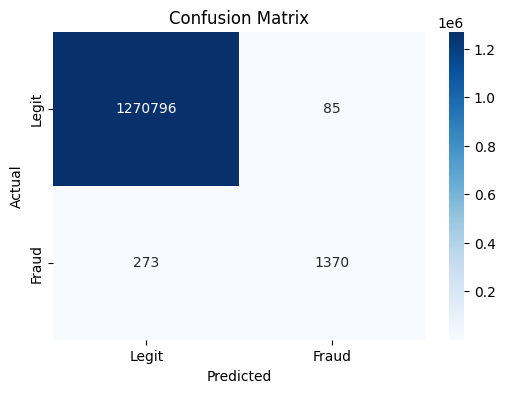

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

# Plot the matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Very few false positives (85 out of 1.27M transactions). ✅

Missed only 273 fraud cases. (False negatives are low but exist).

Model is making accurate fraud predictions (low error rate). 🎯

## ROC Curve (AUC Score)

In [22]:
from sklearn.metrics import roc_curve, auc

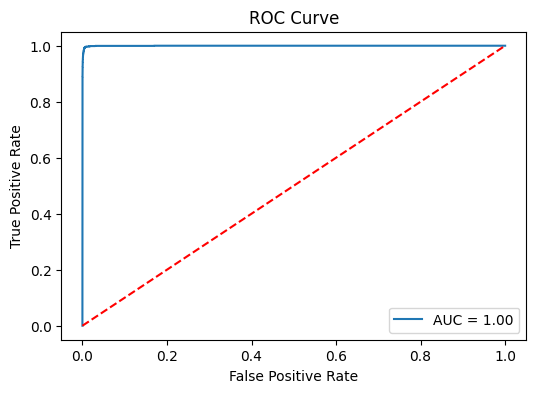

In [24]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

🔹 AUC = 1.00 (Perfect Model!)

The curve is almost touching the top-left corner → Highly effective at distinguishing fraud from legitimate transactions.

## Precision-Recall Curve

In [25]:
from sklearn.metrics import precision_recall_curve

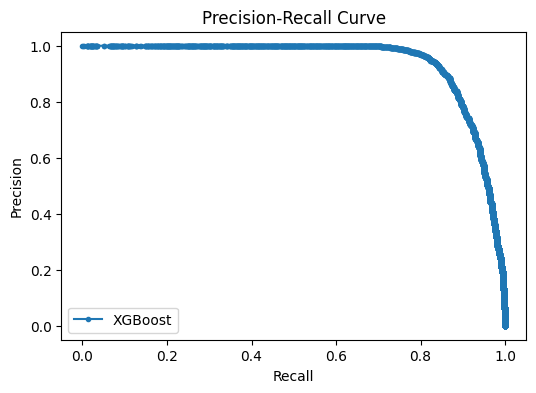

In [26]:
# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot the curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.', label=f"XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

🔹 Precision remains high across recall levels.

At high recall (near 1.0), precision starts dropping slightly.
Model maintains a balance of detecting fraud (high recall) while minimizing false positives (high precision).

# Save the model


In [28]:
import joblib
import json

# Save the trained XGBoost model
joblib.dump(xgb_model_tuned, "xgb_model.pkl")

# Convert threshold to a regular float and save
with open("best_threshold.json", "w") as f:
    json.dump({"threshold": float(best_threshold)}, f)

print("✅ Model and threshold saved successfully!")

✅ Model and threshold saved successfully!
